# Imports

In [402]:
import pandas as pd
import numpy as np

import seaborn as sb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [403]:
df_orig = pd.read_csv("data/auto-insurance-fall-2017/train_auto.csv")

In [404]:
df = df_orig

# Preprocessing

In [405]:
df.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


## Dealing with `NaN` values

How many lines do we have in the dataframe?

In [406]:
len(df.index)

8161

And how many `Nan` values?

In [407]:
df.isna().sum().sum()

2405

We have roughly 30% of `NaN` values. This means that if we drop all rows that have one or more `NaN` cells, in the worst case scenario (i.e. if all `NaN` values are found in different rows), we'll lose 30% of the initial data. Let's try it anyway:

In [408]:
df = df.dropna()
len(df.index)

6045

In practice, we've gone from 8161 to 6045 rows, which is a 26% loss. That's quite a lot. In the future, we'll discuss how to do better.

## Processing columns

We have many columns with non-numeric data. Let's sort this.

In [409]:
df.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,7,1,2946.0,0,34.0,1,12.0,"$125,301",Yes,$0,...,"$17,430",1,Sports Car,no,$0,0,No,0,7.0,Highly Urban/ Urban
8,12,1,2501.0,0,34.0,0,10.0,"$62,978",No,$0,...,"$11,200",1,z_SUV,no,$0,0,No,0,1.0,Highly Urban/ Urban


In [410]:
def dollars_to_float(x):
    x = x.replace(',','.')
    return float(x[1:])

def yes_no_to_int(x):
    return int(x=='Yes')

def MF_to_int(x):
    return int(x=='M')

def education_to_int(x):
    arr = ['<High School', 'z_High School', 'Bachelors', 'Masters', 'PhD']
    for i in range(5):
        if arr[i]==x: return i
        
def job_to_int(x):
    arr = ['Professional', 'z_Blue Collar', 'Clerical', 'Lawyer', 'Manager', 'Home Maker', 'Doctor', 'Student']
    for i in range(8):
        if x==arr[i]: return i
        
def car_use_to_int(x):
    return int(x=='Commercial')

def car_type_to_int(x):
    arr = ['Minivan', 'z_SUV', 'Sports Car', 'Van', 'Pickup', 'Panel Truck']
    for i in range(6):
        if x==arr[i]: return i
        
def red_car_to_int(x):
    return int(x=="yes")

def urbanicity_to_int(x):
    return int(x == 'Highly Urban/ Urban')

In [411]:
df['INCOME'] = df['INCOME'].apply(dollars_to_float)
df['HOME_VAL'] = df['HOME_VAL'].apply(dollars_to_float)
df['BLUEBOOK'] = df['BLUEBOOK'].apply(dollars_to_float)
df['OLDCLAIM'] = df['OLDCLAIM'].apply(dollars_to_float)
df['MSTATUS'] = df['MSTATUS'].apply(yes_no_to_int)
df['PARENT1'] = df['PARENT1'].apply(yes_no_to_int)
df['SEX'] = df['SEX'].apply(MF_to_int)
df['EDUCATION'] = df['EDUCATION'].apply(education_to_int)
df['JOB'] = df['JOB'].apply(job_to_int)
df['CAR_USE'] = df['CAR_USE'].apply(car_use_to_int)
df['CAR_TYPE'] = df['CAR_TYPE'].apply(car_type_to_int)
df['RED_CAR'] = df['RED_CAR'].apply(red_car_to_int)
df['URBANICITY'] = df['URBANICITY'].apply(urbanicity_to_int)
df['REVOKED'] = df['REVOKED'].apply(yes_no_to_int)

<ipython-input-411-75d35187b0eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INCOME'] = df['INCOME'].apply(dollars_to_float)
<ipython-input-411-75d35187b0eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HOME_VAL'] = df['HOME_VAL'].apply(dollars_to_float)
<ipython-input-411-75d35187b0eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [412]:
print(df.dtypes)

INDEX            int64
TARGET_FLAG      int64
TARGET_AMT     float64
KIDSDRIV         int64
AGE            float64
HOMEKIDS         int64
YOJ            float64
INCOME         float64
PARENT1          int64
HOME_VAL       float64
MSTATUS          int64
SEX              int64
EDUCATION        int64
JOB              int64
TRAVTIME         int64
CAR_USE          int64
BLUEBOOK       float64
TIF              int64
CAR_TYPE         int64
RED_CAR          int64
OLDCLAIM       float64
CLM_FREQ         int64
REVOKED          int64
MVR_PTS          int64
CAR_AGE        float64
URBANICITY       int64
dtype: object


All columns now have `int` or `float` data types. Great!

## Dropping useless columns

We can reasonably drop the `RED_CAR` column. We can also drop `TARGET_AMT`, which we won't use in our model (this column could be useful to deal with `NaN` values and try to find a better solution than dropping them brutally, but here this is not what we're trying to achieve).

In [413]:
df = df.drop(columns=['RED_CAR', 'TARGET_AMT'])

Set aside these two columns, let's have a look at the cluster map to see if any columns look like they have no impact on `TARGET_FLAG` and can be dropped:

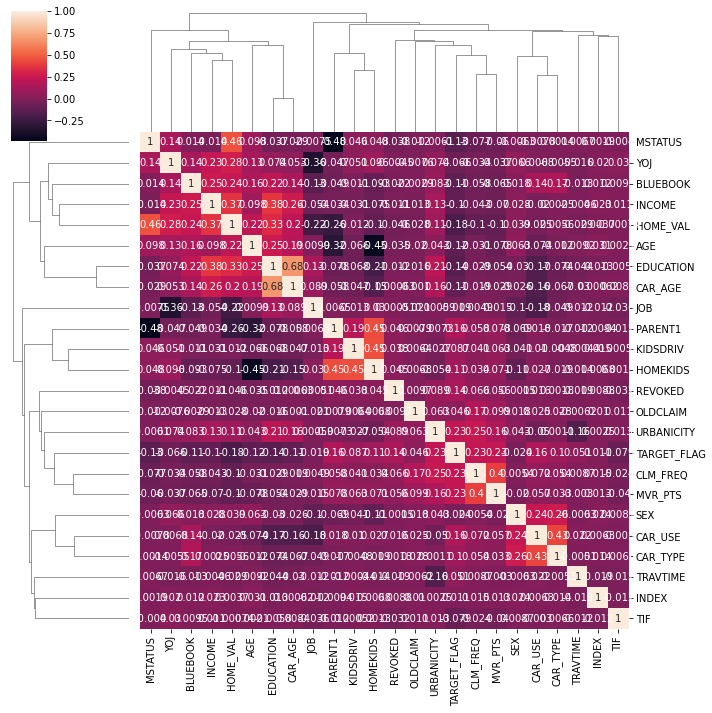

In [414]:
sb.clustermap(df.corr(), annot=True)

Given the matrix, we can try to drop `HOME_VAL`, `EDUCATION` and `TRAVTIME`.

In [415]:
light_df = df.drop(columns = ['HOME_VAL', 'EDUCATION', 'TRAVTIME'])

# Models

## Random Forest

We'll first try using a random forest classifier:

In [426]:
model = RandomForestClassifier()
X, Y  = light_df.drop(columns = ['TARGET_FLAG']), light_df.TARGET_FLAG
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [427]:
mat = confusion_matrix(Y_test, Y_pred)
print(mat)

[[822  53]
 [199 135]]


### Accuracy

In [428]:
accuracy = (mat[0][0]+mat[1][1])/(mat[0][0]+mat[0][1]+mat[0][1]+mat[1][1])
accuracy

0.9002822201317028

Accuracy is 90%, meaning that roughly 1 in 10 predictions was wrong.

### Precision

In [429]:
precision = mat[0][0]/(mat[0][0] + mat[1][0])
precision

0.8050930460333007

Precision is 80%, meaning that if we consider an input for which our model predicted `1`, there is actually a 1 in 5 chance for it to be mistaken.

### Recall

In [430]:
recall = mat[0][0]/(mat[0][0] + mat[0][1])
recall

0.9394285714285714

Recall is 94%, meaning that our model has correctly identified 93% of true positives.

The fact that the recall is so much higher than the precision hints that our model may have a tendency to predict `1` too often.

## XGBoost

Let's now try using another model, for instance XGBoost:

In [431]:
model = XGBClassifier()
X, Y  = light_df.drop(columns = ['TARGET_FLAG']), light_df.TARGET_FLAG
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [432]:
mat = confusion_matrix(Y_test, Y_pred)
print(mat)

[[802  90]
 [159 158]]


### Accuracy

In [433]:
accuracy = (mat[0][0]+mat[1][1])/(mat[0][0]+mat[0][1]+mat[0][1]+mat[1][1])
accuracy

0.8421052631578947

### Precision

In [434]:
precision = mat[0][0]/(mat[0][0] + mat[1][0])
precision

0.8345473465140478

### Recall

In [435]:
recall = mat[0][0]/(mat[0][0] + mat[0][1])
recall

0.899103139013453

Using this new model, we have the same type of results but precision has been a little improved, at the expense of recall. This makes sense given what's been discussed above (the new model may have less of a tendency to predict `1`'s).

## Discussing dropped columns

Let's have a look at the metrics we would have achieved without dropping the columns `HOME_VAL`, `EDUCATION` and `TRAVTIME`.

In [345]:
model = RandomForestClassifier()
X, Y  = light_df.drop(columns = ['TARGET_FLAG']), light_df.TARGET_FLAG
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

mat = confusion_matrix(Y_test, Y_pred)

accuracy = (mat[0][0]+mat[1][1])/(mat[0][0]+mat[0][1]+mat[0][1]+mat[1][1])
precision = mat[0][0]/(mat[0][0] + mat[1][0])
recall = mat[0][0]/(mat[0][0] + mat[0][1])

print("Accuracy: "+str(int(accuracy*100))+"%, Precision: "+str(int(precision*100))+"%, Recall: "+str(int(recall*100))+"%")

Accuracy: 88%, Precision: 80%, Recall: 93%


These metrics show that dropping these columns doesn't really affect the model's performance and was therefore reasonable.

On the opposite, we could have tried to drop more columns which do not seem to impact the model's predicitons: `CAR_AGE`, `INCOME`, `MSTATUS`, `AGE`, `TIF`, `YOJ` and `BLUEBOOK` for instance.

In [369]:
lighter_df = light_df.drop(columns = ['CAR_AGE', 'INCOME', 'MSTATUS', 'AGE', 'TIF', 'YOJ', 'BLUEBOOK'])

model = RandomForestClassifier()
X, Y  = lighter_df.drop(columns = ['TARGET_FLAG']), lighter_df.TARGET_FLAG
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

mat = confusion_matrix(Y_test, Y_pred)

accuracy = (mat[0][0]+mat[1][1])/(mat[0][0]+mat[0][1]+mat[0][1]+mat[1][1])
precision = mat[0][0]/(mat[0][0] + mat[1][0])
recall = mat[0][0]/(mat[0][0] + mat[0][1])

print("Accuracy: "+str(int(accuracy*100))+"%, Precision: "+str(int(precision*100))+"%, Recall: "+str(int(recall*100))+"%")

Accuracy: 85%, Precision: 82%, Recall: 90%


Once again, overall performance is the same as before and indicate that we can safely drop these columns too.

The new cluster map for `lighter_df` goes as follows:

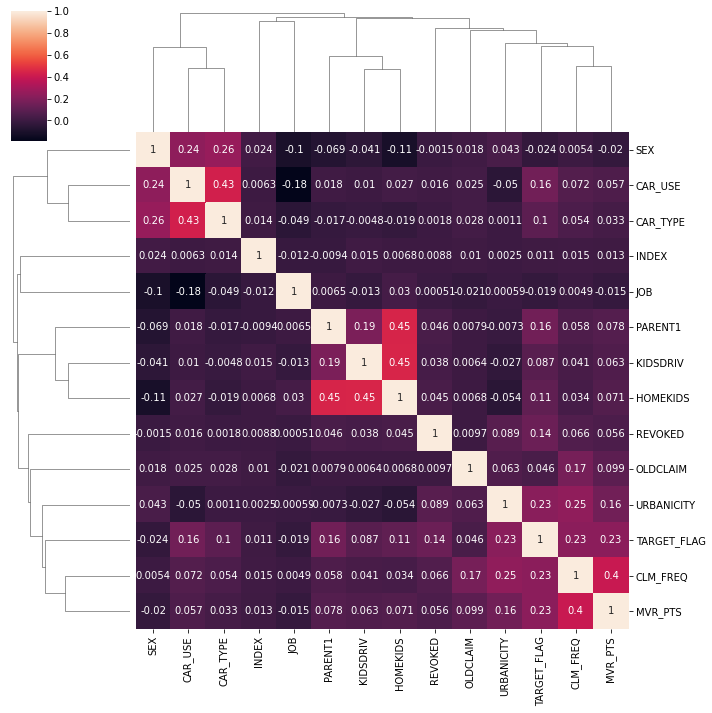

In [370]:
sb.clustermap(lighter_df.corr(), annot=True)

# Further discussion

## Dealing with `NaN` values - II

Let's have a look at the original dataframe, to see in which rows we tend to find `NaN` values: 

In [436]:
df.isna().sum()

INDEX          0
TARGET_FLAG    0
KIDSDRIV       0
AGE            0
HOMEKIDS       0
YOJ            0
INCOME         0
PARENT1        0
HOME_VAL       0
MSTATUS        0
SEX            0
EDUCATION      0
JOB            0
TRAVTIME       0
CAR_USE        0
BLUEBOOK       0
TIF            0
CAR_TYPE       0
OLDCLAIM       0
CLM_FREQ       0
REVOKED        0
MVR_PTS        0
CAR_AGE        0
URBANICITY     0
dtype: int64

This is goos news: the columns with considerable `NaN` values are `YOJ`, `INCOME`, `HOME_VAL`, `CAR_AGE` and `JOB` - all of which have been shown not to impact models' predictions, except for `JOB`.

We can therefore drop these columns first, and then drop remaining `NaN` values. This will allow to drop fewer rows than before, when we did it the other way round.

In [442]:
new_df = df_orig.drop(columns = ['CAR_AGE', 'INCOME','YOJ', 'HOME_VAL'])
new_df = new_df.dropna()

In [443]:
len(new_df.index)

7629

Instead of dropping 2000 rows, we have dropped only 500. Let's see if this allows to achieve better model performance:

In [444]:
new_df = new_df.drop(columns = ['TARGET_AMT', 'RED_CAR', 'EDUCATION', 'TRAVTIME', 'MSTATUS', 'AGE', 'TIF', 'BLUEBOOK'])

In [445]:
new_df['OLDCLAIM'] = new_df['OLDCLAIM'].apply(dollars_to_float)
new_df['PARENT1'] = new_df['PARENT1'].apply(yes_no_to_int)
new_df['SEX'] = new_df['SEX'].apply(MF_to_int)
new_df['JOB'] = new_df['JOB'].apply(job_to_int)
new_df['CAR_USE'] = new_df['CAR_USE'].apply(car_use_to_int)
new_df['CAR_TYPE'] = new_df['CAR_TYPE'].apply(car_type_to_int)
new_df['URBANICITY'] = new_df['URBANICITY'].apply(urbanicity_to_int)
new_df['REVOKED'] = new_df['REVOKED'].apply(yes_no_to_int)

In [446]:
model = RandomForestClassifier()
X, Y  = new_df.drop(columns = ['TARGET_FLAG']), new_df.TARGET_FLAG
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

mat = confusion_matrix(Y_test, Y_pred)

accuracy = (mat[0][0]+mat[1][1])/(mat[0][0]+mat[0][1]+mat[0][1]+mat[1][1])
precision = mat[0][0]/(mat[0][0] + mat[1][0])
recall = mat[0][0]/(mat[0][0] + mat[0][1])

print("Accuracy: "+str(int(accuracy*100))+"%, Precision: "+str(int(precision*100))+"%, Recall: "+str(int(recall*100))+"%")

Accuracy: 81%, Precision: 80%, Recall: 88%


As shown by the new model's metrics, depsite having a greater dataframe, we have not succesfully achieved better performance.

## Dealing with `NaN` values - III

We could go even further when dealing with `NaN` values. Instead of dropping rows with missing cells, we could try to find what missing value could actually have been expected, and give and approximation of this missing value. This would allow us to further increase the dataframe size.

One way of doing this is described in the following steps:

* Let's say we're dealing with a row `i` for which the value from column `A` is missing, that is: `df[A][i] = NaN`

* Find another column `B` which is strongly correlated to `A` (cluster map can help us do this)

* Look at the value in row `i`, column `B` (of course this doesn't work if this value is also `NaN`) - let's call this value `x`: `x=df[B][i]`

* Find rows from the dataframe where value in column `B` is similar to `x`

* Look at the values in column `A` for these rows (again, this doesn't work if those values are `NaN`)

* If these values are "close" to one another, this means we can approximate the original missing value based on these values.

In order to actually put this in practice, we would have to give a definition of what "close" means in the line above.

One way to simplify this is simply to look at the 4 rows of data for which value in column `B` is closest to row `i`'s value, and calculate the average for the values found in column `A` at these rows.

The idea behind this entire process is that if two columns are correlated, and if two rows have (almost) equal values in one column, then they must also have (almost) equal values in the other column.

In our case, replacing `NaN` values by approximations would increase the dataframe size from 7629 rows to 8161, which represents less than a 7% increase. We are therefore not going to go through all this trouble for such a minor improvement, since it would probably not really affect the model performance.